#Implementing an SGAN

##Import dependencies and load the dataset
Use only a fraction of the MNIST 50,000 labeled training dataset (specified by the num_labeled parameter) for training and assume that the remaining are unlabeled. Only sample from the first num_labeled images when generating batches of labeled data and from the remaining (50,000 – num_labeled) images when generating batches of unlabeled examples.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense, Dropout, Flatten, Input, Lambda, Reshape)
from keras.layers import LeakyReLU
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

In [2]:
# Functions to return all num_labeled training examples with labels and to return all 10,000 labeled test images
class Dataset:
    def __init__(self, num_labeled):

        # Number of labeled examples to use for training
        self.num_labeled = num_labeled

        # Load the MNIST dataset
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            # Rescale [0, 255] grayscale pixel values to [-1, 1]
            x = (x.astype(np.float32) - 127.5) / 127.5
            # Expand image dimensions to width x height x channels
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        # Training data
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        # Testing data
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [3]:
# Number of labeled examples to use (the rest will be used as unlabeled)
num_labeled = 100

dataset = Dataset(num_labeled)

11490434/11490434 [==============================] - 2s 0us/step


##Input dimensions

In [4]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Noise vector input to Generator
z_dim = 100

# Classes in the dataset
num_classes = 10

##The Generator
The Generator network uses transposed convolution layers and transforms the random noise input vector into 28 × 28 × 1 image.

In [5]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

## The Discriminator
The SGAN Discriminator has a dual objective. To Distinguish real examples from fake. And for the real examples, to accurately classify their label.

In [6]:
def build_discriminator_net(img_shape):

    model = Sequential()

    # Convolutional layer from 28x28x1 into 14x14x32 tensor
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer from 14x14x32 into 7x7x64 tensor
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer from 7x7x64 tensor into 3x3x128 tensor
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Droupout given the increased complexity of the SGAN classification task
    model.add(Dropout(0.5))

    # Flatten the tensor
    model.add(Flatten())

    # Fully connected layer with num_classes neurons
    model.add(Dense(num_classes))

    return model

##Supervised SGAN Discriminator 
Define the two Discriminator outputs, one for the supervised multiclass classification (using softmax) and the other for the unsupervised, binary classification (using sigmoid).

In [7]:
def build_discriminator_supervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation on top of core discriminatior giving predicted probability of the real class distribution 
    model.add(Activation('softmax'))

    return model

##Usupervised SGAN Discriminator

In [8]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

##Build the models

In [9]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator and discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

#### The core discriminator network

In [10]:
# These layers are shared during supervised and unsupervised training
discriminator_net = build_discriminator_net(img_shape)

# Build/compile the Discriminator for supervised training (multiclass classification)
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

# Build/compile the Discriminator for unsupervised training (binary classification)
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy', optimizer=Adam())

### Build the Generator

In [11]:
generator = build_generator(z_dim)

# Keep Discriminator parameters constant for Generator training
discriminator_unsupervised.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator_unsupervised) # Note the use of unsupervised Discriminator output
gan.compile(loss='binary_crossentropy', optimizer=Adam())

### Implement SGAN training algorithm

In [12]:
supervised_losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get labeled examples
        imgs, labels = dataset.batch_labeled(batch_size)

        # One-hot encode labels
        labels = to_categorical(labels, num_classes=num_classes)

        # Get unlabeled examples
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train on real labeled examples
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

        # Train on real unlabeled examples
        d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)

        # Train on fake examples
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:

            # Save Discriminator supervised classification loss to be plotted after training
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy, d_loss_unsupervised, g_loss))

##Train and plot the Model
Use a smaller batch size (32) given limited labeled training examples (100). The number of iterations is increased until the Discriminator’s supervised loss plateaus.

In [13]:
# Set hyperparameters
iterations = 8000
batch_size = 32
sample_interval = 800

# Train the SGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
5600 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000175]
1/1 [==============================] - 0s 16ms/step
6400 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000272]
1/1 [==============================] - 0s 19ms/step
7200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000054]
1/1 [==============================] - 0s 16ms/step
8000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.0000] [G loss: 0.000028]


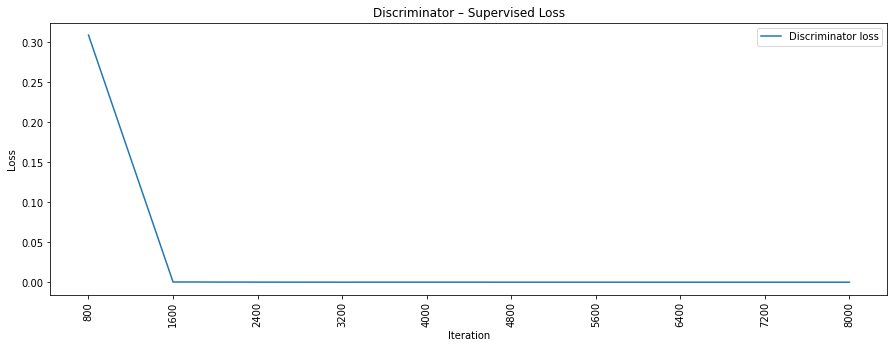

In [14]:
losses = np.array(supervised_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

##Training and testing SGAN accuracy  
The supervised training achieved 100% accuracy since there are only 100 labeled examples from which to sample. So the model just memorized the training dataset. How well the classifier generalizes to unseen data is more important.

In [15]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 19ms/step - loss: 1.8270e-05 - accuracy: 1.0000
Training Accuracy: 100.00%


In [16]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 4ms/step - loss: 2.4958 - accuracy: 0.6737
Test Accuracy: 67.37%


##Comparison to a fully supervised classifier
Compare the performance to a fully supervised classifier with the same network architecture as the SGAN Discriminator.

In [17]:
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

In [18]:
imgs, labels = dataset.training_set()

# One-hot encode labels
labels = to_categorical(labels, num_classes=num_classes)

# Train the classifier
training = mnist_classifier.fit(x=imgs, y=labels,batch_size=32, epochs=30, verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
4/4 [==============================] - 1s 22ms/step - loss: 2.3760 - accuracy: 0.2900
Epoch 2/30
4/4 [==============================] - 0s 6ms/step - loss: 1.0966 - accuracy: 0.6600
Epoch 3/30
4/4 [==============================] - 0s 6ms/step - loss: 0.5295 - accuracy: 0.8300
Epoch 4/30
4/4 [==============================] - 0s 6ms/step - loss: 0.3000 - accuracy: 0.9600
Epoch 5/30
4/4 [==============================] - 0s 5ms/step - loss: 0.2312 - accuracy: 0.9700
Epoch 6/30
4/4 [==============================] - 0s 6ms/step - loss: 0.1642 - accuracy: 0.9700
Epoch 7/30
4/4 [==============================] - 0s 11ms/step - loss: 0.1022 - accuracy: 0.9800
Epoch 8/30
4/4 [==============================] - 0s 6ms/step - loss: 0.0611 - accuracy: 0.9900
Epoch 9/30
4/4 [==============================] - 0s 10ms/step - loss: 0.0587 - accuracy: 0.9900
Epoch 10/30
4/4 [==============================] - 0s 7ms/step - loss: 0.1101 - accuracy: 0.9700
Epoch 11/30
4/4 [===================

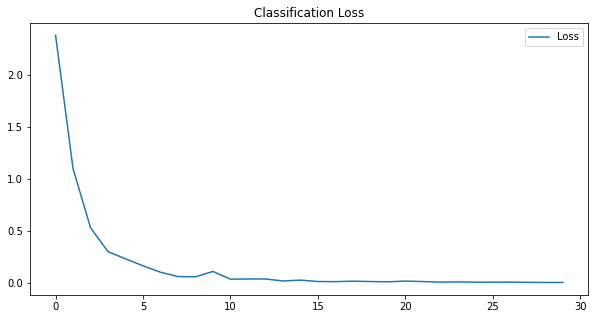

In [19]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

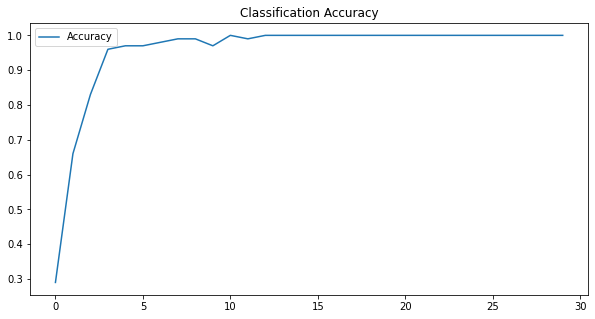

In [20]:
# Plot classification accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()

In [21]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 5ms/step - loss: 1.7793 - accuracy: 0.8800
Training Accuracy: 88.00%


In [22]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 4ms/step - loss: 2.0457 - accuracy: 0.4375
Test Accuracy: 43.75%


##Conclusion
The SGAN improved the test accuracy from 43.75% to 67.37%, so by more than 50%.

# References
Codes from the book *GANs in Action* by Jakub Langr and Vladimir Bok.